In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import time
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


In [24]:
#variables
VAL_PCT = 0.2
N_EVENTS = 10000
EPOCHS = 100
CUDA = torch.device('cuda') 
MODEL_NAME = "jet_nr-" + str(int(time.time()))
print(MODEL_NAME)
N_JETS = [0, 2, 3]
OUTPUTS = len(N_JETS)
DATAPATH = "../data/histograms/"
FILENAMES = [f"jets_part1_njets_{n}_80x80.pkl" for n in N_JETS]

jet_nr-1643813107


In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(80,80).view(-1,1,80,80)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, OUTPUTS) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        #print(x)[0]
        x = self.convs(x)
        #print(x)[0]
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        #print(x)[0]
        x = F.relu(self.fc1(x))
        #print(x)[0]
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


In [26]:
class CalorimeterDataset(Dataset):
    def __init__(self, images, labels):
            self.img_labels = labels
            self.images = images
            
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.img_labels[idx]
        return image, label

def load_pickle_file(path, file_name):
    return np.array(pickle.load(open(path + file_name, 'rb') ))

def label_maker(njets, nevents):
    a = torch.zeros(nevents*len(njets), len(njets), dtype=torch.int)
    for i in range(len(njets)):
        for j in range(nevents):
            a[nevents*i + j][i] = 1
    return a

def normalize(AA, batchsize):
    print(AA.size())
    AA = AA.view(AA.size(0), -1)
    AA -= AA.min(1, keepdim=True)[0]
    AA /= AA.max(1, keepdim=True)[0]
    AA = AA.view(batchsize, 80, 80, 1)
    print(AA.size())
    return AA

def load_data(input_files, data_path):
    val_size = int(N_EVENTS*VAL_PCT)
    train_size = int(N_EVENTS*(1-VAL_PCT))
    
    Cal_train = torch.cat( 
                    [torch.tensor(load_pickle_file(data_path, input_files[i])[0:train_size]) for i in range(len(input_files))]
                    ).unsqueeze(3).float().cuda()
    Cal_train = normalize(Cal_train, len(Cal_train))
    labels_train = label_maker(N_JETS, train_size).float().cuda()
    print(len(Cal_train), len(labels_train))
    #labels_train = label_maker(labels_train, MAX_JETS)

    Cal_test = torch.cat( 
                    [torch.tensor(load_pickle_file(data_path, input_files[i])[(train_size+1):(train_size+1+val_size)]) for i in range(len(input_files))]
                    ).unsqueeze(3).float().cuda()
    Cal_test = normalize(Cal_test, len(Cal_test))
    labels_test = label_maker(N_JETS, val_size).float().cuda()
    print(len(Cal_test), len(labels_test))
    
    train_dataset = CalorimeterDataset(Cal_train, labels_train)
    test_dataset = CalorimeterDataset(Cal_test, labels_test)
    
    return train_dataset, test_dataset




In [27]:
#load data
traindata, testdata = load_data(FILENAMES, DATAPATH)


torch.Size([24000, 80, 80, 1])
torch.Size([24000, 80, 80, 1])
24000 24000
torch.Size([6000, 80, 80, 1])
torch.Size([6000, 80, 80, 1])
6000 6000


[tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]), tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]]), tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])]


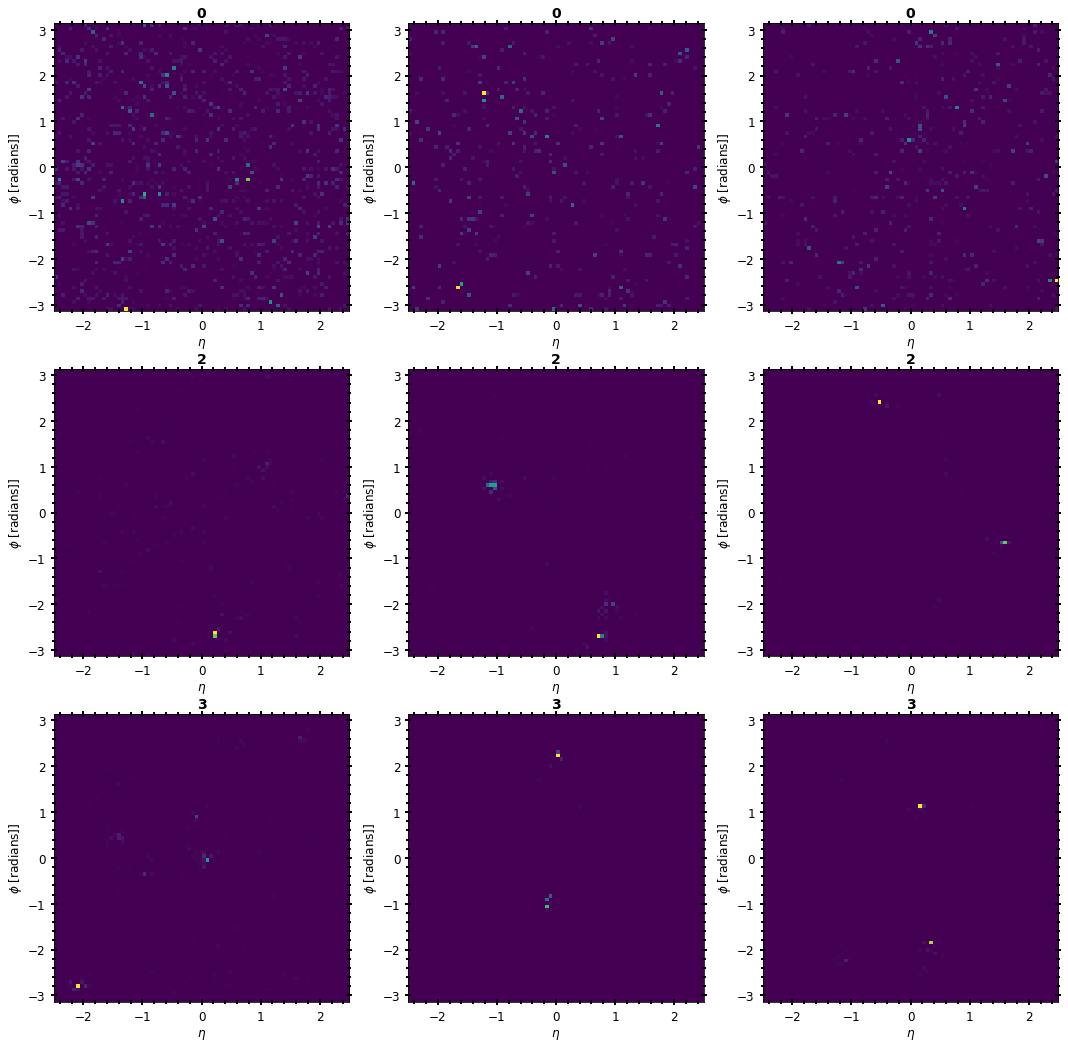

In [28]:
img_per_row = 3
k = [[i]*img_per_row for i in range(OUTPUTS)]
for i in range(len(k)):
    row = k[i]
    row = [item*(N_EVENTS*(VAL_PCT)) for item in row]
    row = [int(item + np.random.randint(1, high = 100)) for item in row]
    k[i] = row

images = [testdata.images[item].cpu() for item in k]
labels = [testdata.img_labels[item].cpu() for item in k]
print(labels)

def cal_image_plot(ax, n_jets):
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=12)
    ax.set_xlabel(r"$\eta$", fontsize=12)
    ax.set_title(str(n_jets), fontsize=14,weight="bold")
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=12, pad=5, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()


fig, axs = plt.subplots(nrows = OUTPUTS, ncols = img_per_row, figsize = (img_per_row*6, OUTPUTS*6))
for i in range (len(k)):
    for j in range(img_per_row):
        cal_image_plot(axs[i][j], int(N_JETS[i]))
        axs[i][j].imshow(images[i][j], extent=[-2.5, 2.5, -np.pi, np.pi], aspect='auto')


In [29]:

def fwd_pass(net, X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X.view(-1, 1, 80, 80).cuda())
    #print(len(outputs), len(y))
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = F.cross_entropy(outputs, y.cuda()) # loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

def test(net, data, size = 32):
    dataset = DataLoader(data, size, shuffle=True) #shuffle data and choose batch size
    X, y = next(iter(dataset)) #get a random batch
    val_acc, val_loss = fwd_pass(net, X, y)
    return val_acc, val_loss
    
def predict(net, data):
    dataset = DataLoader(data, 1, shuffle=True) #shuffle data and choose batch size
    prediction = torch.zeros(len(dataset))
    truth = torch.zeros(len(dataset))
    i = 0
    for data in tqdm(dataset):
        X, y = data
        output = net(X.view(-1, 1, 80, 80).cuda())
        prediction[i] = torch.argmax(output)
        truth[i] = torch.argmax(y)
        i = i +1
    return truth, prediction
        

def train(net, traindata, testdata, size, epochs):
    dataset = DataLoader(traindata, size, shuffle=True)
    df_labels = ["Loss", "Accuracy", "Validation loss", "Validation accuracy", "Epoch", "Iteration"]
    df_data = [[0], [0], [0], [0], [0], [0]]
    df = pd.DataFrame(dict(zip(df_labels, df_data)))
    i = 0
    for epoch in tqdm(range(epochs)):
        for data in dataset:
            i = i+1
            X, y = data
            acc, loss = fwd_pass(net, X, y, train=True)
            if i % 10 == 0:
                val_acc, val_loss = test(net, testdata, size=size)
                df_data = [float(loss), acc, float(val_loss), val_acc, epoch, i]
                #print(df_labels, df_data)
                new_df = pd.DataFrame(dict(zip(df_labels, df_data)), index=[0])
                df = pd.concat([df, new_df], ignore_index=True)
    return df

In [30]:
#create NN
net = Net()
net.to(device = CUDA)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [31]:
testimage, testlabel = traindata.images[0], traindata.img_labels[0]
net(testimage.view(-1, 1, 80, 80).cuda())

tensor([[0.3225, 0.3341, 0.3433]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [32]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)
training_results = train(net, traindata, testdata, 100, 20)

100%|██████████| 20/20 [01:22<00:00,  4.11s/it]


<AxesSubplot:xlabel='Iteration'>

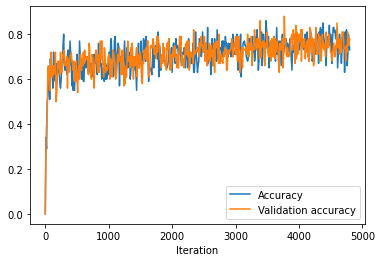

In [33]:
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"])

<AxesSubplot:xlabel='Iteration'>

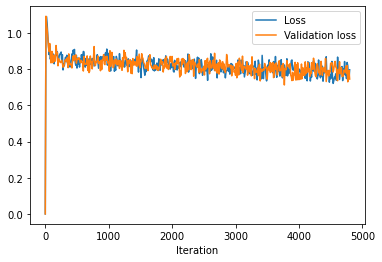

In [34]:
training_results.plot("Iteration", ["Loss", "Validation loss"])

In [35]:
truth, preds = predict(net, testdata)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
print(preds[:50])
print(truth[:50])

100%|██████████| 6000/6000 [00:04<00:00, 1247.66it/s]

tensor([1., 0., 0., 2., 1., 0., 1., 2., 2., 2., 1., 1., 0., 2., 1., 1., 2., 1.,
        1., 0., 0., 2., 0., 2., 1., 0., 0., 2., 2., 2., 2., 2., 2., 1., 2., 2.,
        2., 1., 2., 0., 0., 1., 1., 2., 1., 1., 0., 2., 1., 2.])
tensor([1., 0., 0., 2., 1., 1., 1., 2., 1., 1., 1., 0., 0., 1., 1., 2., 1., 2.,
        2., 0., 0., 2., 0., 1., 1., 0., 0., 1., 1., 1., 2., 2., 1., 1., 2., 1.,
        2., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 2., 2., 1.])


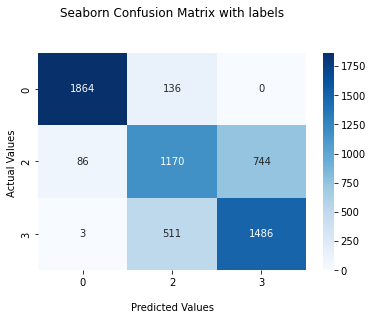

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

#Generate the confusion matrix
cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"])
ax = sn.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(N_JETS)
ax.yaxis.set_ticklabels(N_JETS)

## Display the visualization of the Confusion Matrix.
plt.show()

(0.0, 4.0)

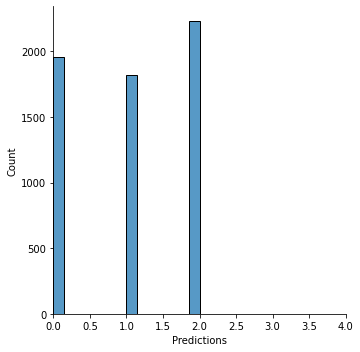

In [37]:
import seaborn as sn
sn.displot(confusion, x="Predictions", )
plt.xlim(0, 4)

(0.0, 4.0)

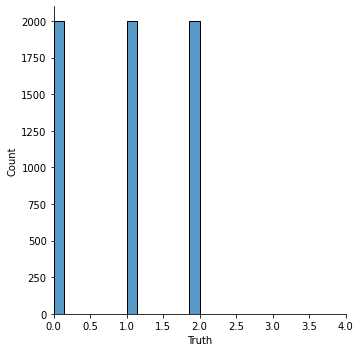

In [38]:
sn.displot(confusion, x="Truth")
plt.xlim(0, 4)